In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
df_patients = pd.read_excel('epic.xlsx', sheet_name=0)
df_admissions = pd.read_excel('epic.xlsx', sheet_name=1)
df_icu_stays = pd.read_excel('epic.xlsx', sheet_name=2)
df_bypass_surgeries = pd.read_excel('epic.xlsx', sheet_name=3)
df_haemoglobins = pd.read_excel('epic.xlsx', sheet_name=4)
df_transfusions = pd.read_excel('epic.xlsx', sheet_name=5)

In [3]:
def df_admissions_patiens(packed_red_cells,name):
    female = packed_red_cells.loc[packed_red_cells.Gender == 'F' ].VOLUME
    male = packed_red_cells.loc[packed_red_cells.Gender == 'M' ].VOLUME
    plt.hist(male,  edgecolor="black",label= f"male | {len(packed_red_cells.loc[packed_red_cells.Gender == 'M'])}")
    plt.hist(female, edgecolor="black",label= f"female | {len(packed_red_cells.loc[packed_red_cells.Gender == 'F'])}")
    plt.xlabel("Blood transfusion totalamount")
    plt.ylabel("Number of Patient")
    plt.title("Number of Patient in each group")
    plt.legend()
    plt.savefig(f'Bloodtransfusion_plots/{name}_histplot_bloodtransfusion_volume.png')
    plt.show()



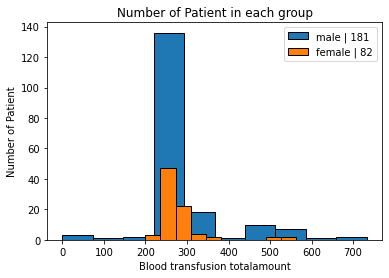

In [4]:
packed_red_cells = df_transfusions.join(df_patients.set_index('PATIENT_NUMBER'), on='PATIENT_NUMBER')
df_admissions_patiens(packed_red_cells, "EPIC")

In [5]:
blood_transfusion_count = df_transfusions.join(df_patients.set_index('PATIENT_NUMBER'), on='PATIENT_NUMBER')[["PATIENT_NUMBER", "Gender", "TRANSFUSION_NUMBER"]].groupby(["PATIENT_NUMBER", "Gender"]).count().reset_index()
blood_transfusion_count['counts'] = blood_transfusion_count['TRANSFUSION_NUMBER']

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


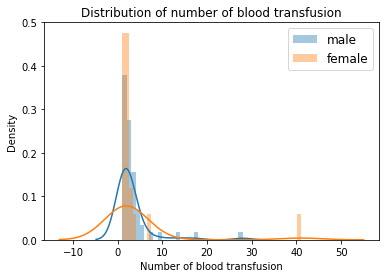

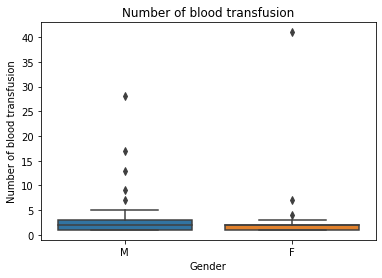

In [6]:
def histplot_bloodtransfusion_counts(blood_transfusion_count,name):
    male_Hb = blood_transfusion_count[blood_transfusion_count.Gender == 'M']
    sns.distplot(male_Hb['counts'], label='male')

    female_Hb =blood_transfusion_count[blood_transfusion_count.Gender == 'F']
    sns.distplot(female_Hb['counts'],label='female')

    plt.legend(prop={'size': 12})
    plt.title('Distribution of number of blood transfusion')
    plt.xlabel('Number of blood transfusion')
    plt.ylabel('Density')
    plt.savefig(f'Bloodtransfusion_plots/{name}_histplot_numberOfbloodTransfusion_gender.png')
    plt.show()
    
    

def boxplot_bloodtransfusion_counts(blood_transfusion_count,name):
    sns.boxplot(x="Gender", y='counts', data=blood_transfusion_count)
    plt.title("Number of blood transfusion")
    plt.ylabel('Number of blood transfusion')
    plt.savefig(f'Bloodtransfusion_plots/{name}_boxplot_numberOfbloodTransfusion_gender.png')
    plt.show()

histplot_bloodtransfusion_counts(blood_transfusion_count,"EPIC")
boxplot_bloodtransfusion_counts(blood_transfusion_count,"EPIC")

In [7]:
first_blood_transfusion = df_transfusions[df_transfusions.groupby("ADMISSION_NUMBER")['BLOOD_START_TIME'].rank() == 1].sort_values("ADMISSION_NUMBER")[["ADMISSION_NUMBER", "PATIENT_NUMBER", "BLOOD_START_TIME", "VOLUME"]]

result = first_blood_transfusion.join(blood_transfusion_count.set_index("PATIENT_NUMBER")[['counts']], on='PATIENT_NUMBER').rename(columns={"counts" : "blood_counts"})
result

,ADMISSION_NUMBER,PATIENT_NUMBER,BLOOD_START_TIME,VOLUME,blood_counts
115,2,268,2021-06-19 16:45:00,224.00,5
20,8,199,2022-03-12 13:22:00,255.00,2
211,12,1,2021-12-19 17:59:00,271.97,1
66,16,196,2022-04-26 07:00:00,278.00,3
142,18,64,2022-06-25 10:46:00,338.67,1
...,...,...,...,...,...
32,249,243,2022-03-11 03:49:00,382.00,1
57,252,56,2021-02-24 18:34:00,35.00,1
85,257,165,2021-05-08 10:06:00,518.00,2
108,259,128,2021-07-24 10:58:00,496.00,1


In [8]:
df1 = df_haemoglobins[['ADMISSION_NUMBER', 'RESULT', 'SPECIMEN_TAKEN_TIME']].join(result.set_index('ADMISSION_NUMBER'), on="ADMISSION_NUMBER").dropna()
df1 = df1[df1.SPECIMEN_TAKEN_TIME > df1.BLOOD_START_TIME]
df1 = df1[df1.groupby("ADMISSION_NUMBER")['SPECIMEN_TAKEN_TIME'].rank() == 1].rename(columns={"RESULT" : "post_transfusion", "SPECIMEN_TAKEN_TIME": "charttime_after"}).sort_values("ADMISSION_NUMBER").reset_index(drop=True)
df1

,ADMISSION_NUMBER,post_transfusion,charttime_after,PATIENT_NUMBER,BLOOD_START_TIME,VOLUME,blood_counts
0,2,82,2021-06-19 18:29:00,268.0,2021-06-19 16:45:00,224.00,5.0
1,8,113,2022-03-12 14:02:00,199.0,2022-03-12 13:22:00,255.00,2.0
2,12,84,2021-12-20 01:50:00,1.0,2021-12-19 17:59:00,271.97,1.0
3,16,76,2022-04-27 14:56:00,196.0,2022-04-26 07:00:00,278.00,3.0
4,18,89,2022-06-25 15:29:00,64.0,2022-06-25 10:46:00,338.67,1.0
...,...,...,...,...,...,...,...
57,249,83,2022-03-11 05:15:00,243.0,2022-03-11 03:49:00,382.00,1.0
58,252,80,2021-02-24 18:59:00,56.0,2021-02-24 18:34:00,35.00,1.0
59,257,86,2021-05-08 12:26:00,165.0,2021-05-08 10:06:00,518.00,2.0
60,259,88,2021-07-24 16:29:00,128.0,2021-07-24 10:58:00,496.00,1.0


In [9]:
df2 = df_haemoglobins[['ADMISSION_NUMBER', 'RESULT', 'SPECIMEN_TAKEN_TIME']].join(result.set_index('ADMISSION_NUMBER'), on="ADMISSION_NUMBER").dropna()
df2 = df2[df2.SPECIMEN_TAKEN_TIME < df2.BLOOD_START_TIME]
df2 = df2.sort_values('SPECIMEN_TAKEN_TIME').groupby('ADMISSION_NUMBER').last().sort_values("ADMISSION_NUMBER").reset_index().rename(columns = {"RESULT" : "pre_transfusion", "SPECIMEN_TAKEN_TIME": "charttime_before"})
df2

,ADMISSION_NUMBER,pre_transfusion,charttime_before,PATIENT_NUMBER,BLOOD_START_TIME,VOLUME,blood_counts
0,2,71,2021-06-19 16:24:00,268.0,2021-06-19 16:45:00,224.00,5.0
1,8,91,2022-03-12 12:52:00,199.0,2022-03-12 13:22:00,255.00,2.0
2,12,69,2021-12-19 04:35:00,1.0,2021-12-19 17:59:00,271.97,1.0
3,16,74,2022-04-26 06:42:00,196.0,2022-04-26 07:00:00,278.00,3.0
4,18,75,2022-06-25 05:49:00,64.0,2022-06-25 10:46:00,338.67,1.0
...,...,...,...,...,...,...,...
56,249,76,2022-03-11 00:01:00,243.0,2022-03-11 03:49:00,382.00,1.0
57,252,72,2021-02-24 17:51:00,56.0,2021-02-24 18:34:00,35.00,1.0
58,257,76,2021-05-08 02:04:00,165.0,2021-05-08 10:06:00,518.00,2.0
59,259,71,2021-07-24 02:35:00,128.0,2021-07-24 10:58:00,496.00,1.0


In [10]:
result = df2.drop(columns=["BLOOD_START_TIME", "VOLUME", "PATIENT_NUMBER", "blood_counts"]).join(df1.set_index("ADMISSION_NUMBER"), on="ADMISSION_NUMBER")
result

,ADMISSION_NUMBER,pre_transfusion,charttime_before,post_transfusion,charttime_after,PATIENT_NUMBER,BLOOD_START_TIME,VOLUME,blood_counts
0,2,71,2021-06-19 16:24:00,82.0,2021-06-19 18:29:00,268.0,2021-06-19 16:45:00,224.00,5.0
1,8,91,2022-03-12 12:52:00,113.0,2022-03-12 14:02:00,199.0,2022-03-12 13:22:00,255.00,2.0
2,12,69,2021-12-19 04:35:00,84.0,2021-12-20 01:50:00,1.0,2021-12-19 17:59:00,271.97,1.0
3,16,74,2022-04-26 06:42:00,76.0,2022-04-27 14:56:00,196.0,2022-04-26 07:00:00,278.00,3.0
4,18,75,2022-06-25 05:49:00,89.0,2022-06-25 15:29:00,64.0,2022-06-25 10:46:00,338.67,1.0
...,...,...,...,...,...,...,...,...,...
56,249,76,2022-03-11 00:01:00,83.0,2022-03-11 05:15:00,243.0,2022-03-11 03:49:00,382.00,1.0
57,252,72,2021-02-24 17:51:00,80.0,2021-02-24 18:59:00,56.0,2021-02-24 18:34:00,35.00,1.0
58,257,76,2021-05-08 02:04:00,86.0,2021-05-08 12:26:00,165.0,2021-05-08 10:06:00,518.00,2.0
59,259,71,2021-07-24 02:35:00,88.0,2021-07-24 16:29:00,128.0,2021-07-24 10:58:00,496.00,1.0


In [11]:
result = result.join(df_patients[['PATIENT_NUMBER', "Gender"]].set_index("PATIENT_NUMBER"), on="PATIENT_NUMBER").rename(columns = {"ADMISSION_NUMBER" : "hadm_id", "BLOOD_START_TIME": "first_blood_transfusion_starttime", "Gender": "gender"}).drop(columns=['VOLUME', "PATIENT_NUMBER"])
result


,hadm_id,pre_transfusion,charttime_before,post_transfusion,charttime_after,first_blood_transfusion_starttime,blood_counts,gender
0,2,71,2021-06-19 16:24:00,82.0,2021-06-19 18:29:00,2021-06-19 16:45:00,5.0,M
1,8,91,2022-03-12 12:52:00,113.0,2022-03-12 14:02:00,2022-03-12 13:22:00,2.0,M
2,12,69,2021-12-19 04:35:00,84.0,2021-12-20 01:50:00,2021-12-19 17:59:00,1.0,M
3,16,74,2022-04-26 06:42:00,76.0,2022-04-27 14:56:00,2022-04-26 07:00:00,3.0,M
4,18,75,2022-06-25 05:49:00,89.0,2022-06-25 15:29:00,2022-06-25 10:46:00,1.0,M
...,...,...,...,...,...,...,...,...
56,249,76,2022-03-11 00:01:00,83.0,2022-03-11 05:15:00,2022-03-11 03:49:00,1.0,M
57,252,72,2021-02-24 17:51:00,80.0,2021-02-24 18:59:00,2021-02-24 18:34:00,1.0,M
58,257,76,2021-05-08 02:04:00,86.0,2021-05-08 12:26:00,2021-05-08 10:06:00,2.0,F
59,259,71,2021-07-24 02:35:00,88.0,2021-07-24 16:29:00,2021-07-24 10:58:00,1.0,M


In [12]:
result['description'] = "Hemoglobin"
result['valueuom'] = "g/dL"
result['labevent_time_diff_min'] = (result.charttime_after - result.charttime_before).dt.seconds/60
result['labevent_before_tranfusion_diff_min'] = (result.first_blood_transfusion_starttime - result.charttime_before).dt.seconds/60
result['labevent_after_tranfusion_diff_min'] = (result.charttime_after - result.first_blood_transfusion_starttime).dt.seconds/60
result['value_diff'] = result.post_transfusion - result.pre_transfusion
result = result[['hadm_id', 'gender', 'description', 'pre_transfusion', 'post_transfusion', 'value_diff', 'valueuom', 'charttime_before', 'first_blood_transfusion_starttime', 'charttime_after', 'labevent_time_diff_min', 'labevent_before_tranfusion_diff_min', 'labevent_after_tranfusion_diff_min', 'blood_counts']]

In [13]:
def scatter_ValueDiff_Pretransfusion(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, x="pre_transfusion", y="value_diff", hue="gender")
    plt.xlabel('Pre-transfusion value')
    plt.ylabel("Value diff")
    plt.title("Value Diff vs Pre-transfusion")
    plt.savefig(f'labevent_plots/{name}_scatter_ValueDiff_Pretransfusion.png')
    plt.show()

def scatter_ValueDiff_Posttransfusion(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, x="post_transfusion", y="value_diff", hue="gender")
    plt.xlabel('Post-transfusion value')
    plt.ylabel("Value diff")
    plt.title("Value diff vs Post-transfusion, in g/dL")
    plt.savefig(f'labevent_plots/{name}_scatter_ValueDiff_Posttransfusion.png')
    plt.show()
    
def scatter_Counts_Pretransfusion(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, x="pre_transfusion", y="blood_counts", hue="gender")
    plt.xlabel('Pre-transfusion value')
    plt.ylabel("Blood transfusion counts")
    plt.title("Blood transfusion counts vs Pre-transfusion, in g/dL")
    plt.savefig(f'labevent_plots/{name}_scatter_Counts_Pretransfusion.png')
    plt.show()
    
def boxplot_Pretransfusion_Bloodtransfusion(df,name):
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df, x='blood_counts', y='pre_transfusion')
    plt.ylabel('Pre-transfusion value')
    plt.xlabel("Blood transfusion counts")
    plt.savefig(f'labevent_plots/{name}_boxplot_Pretransfusion_Bloodtransfusion.png')
    plt.show()

def boxplot_Posttransfusion_Bloodtransfusion(df,name):
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df, x='blood_counts', y='post_transfusion')
    plt.savefig(f'labevent_plots/{name}_boxplot_Posttransfusion_Bloodtransfusion.png')
    plt.show()

def multiline_Pretransfusion_Bloodtransfusion(df,name):
    row = 3
    col = 1
    fig, axes = plt.subplots(row,sharex=True, figsize=(16,8))
    fig.suptitle('Pre-transfusion value for patient with different number of blood transfusion')


    for axes_num1 in range(3):

        count = axes_num1+1

        if(count==3):
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts >= count)]
        else:
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts == count)]


        sns.kdeplot(ax=axes[axes_num1],x= partial_fbt_time_differece_Hb['pre_transfusion'],label='All')
        mean= partial_fbt_time_differece_Hb.mean().pre_transfusion

        if(count==3):
            axes[axes_num1].set_title('Blood transfusion >='+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)))
        else:
            axes[axes_num1].set_title('Blood transfusion '+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)))

        axes[2].set_xlabel("Pre-transfusion value")
        axes[axes_num1].legend(loc='upper right')
    fig.savefig(f'labevent_plots/{name}_multiline_Pretransfusion_Bloodtransfusion.png')
    fig.show()

def multiline_Pretransfusion_Bloodtransfusion_gender(df,name):
    row = 3
    col = 1
    fig, axes = plt.subplots(row,sharex=True, figsize=(16,8))
    fig.suptitle('Pre-transfusion value for patient with different number of blood transfusion')


    for axes_num1 in range(3):
        count = axes_num1+1

        if(count==3):
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts >= count)]
        else:
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts == count)]

        male_Hb = partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'M']
        sns.kdeplot(ax=axes[axes_num1],x=male_Hb['pre_transfusion'], label='male')
        female_Hb =partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'F']
        sns.kdeplot(ax=axes[axes_num1],x=female_Hb['pre_transfusion'],label='female')
        sns.kdeplot(ax=axes[axes_num1],x= partial_fbt_time_differece_Hb['pre_transfusion'],label='All')
        mean= partial_fbt_time_differece_Hb.mean().pre_transfusion
        fmean = female_Hb.pre_transfusion.mean()
        mmean= male_Hb.pre_transfusion.mean()

        if(count==3):
            axes[axes_num1].set_title('Blood transfusion >='+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+ '| Mean ' + str(round(mean,3)) +'| F Mean '+str(round(fmean,3)) + '| M Mean '+str(round(mmean,3)))
        else:
            axes[axes_num1].set_title('Blood transfusion '+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)) +'| F Mean '+str(round(fmean,3)) + '| M Mean '+str(round(mmean,3)))


        axes[2].set_xlabel("Pre-transfusion value")
        axes[axes_num1].legend(loc='upper right')
    fig.savefig(f'labevent_plots/{name}_multiline_Pretransfusion_Bloodtransfusion_gender.png')
    fig.show()

def multiline_Posttransfusion_Bloodtransfusion_gender(df,name):
    row = 3
    col = 1
    fig, axes = plt.subplots(row,sharex=True, figsize=(16,8))
    fig.suptitle('Post-transfusion value for patient with different number of blood transfusion')


    for axes_num1 in range(3):
        count = axes_num1+1

        if(count==3):
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts >= count)]
        else:
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts == count)]

        male_Hb = partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'M']
        sns.kdeplot(ax=axes[axes_num1],x=male_Hb['post_transfusion'], label='male')
        female_Hb =partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'F']
        sns.kdeplot(ax=axes[axes_num1],x=female_Hb['post_transfusion'],label='female')
        sns.kdeplot(ax=axes[axes_num1],x= partial_fbt_time_differece_Hb['post_transfusion'],label='All')
        mean= partial_fbt_time_differece_Hb.mean().post_transfusion
        fmean = female_Hb.pre_transfusion.mean()
        mmean= male_Hb.pre_transfusion.mean()

        if(count==3):
            axes[axes_num1].set_title('Blood transfusion >='+str(count)+  '|Patients '+str(len(partial_fbt_time_differece_Hb))+ '| Mean ' + str(round(mean,3))+'| F Mean '+str(round(fmean,3)) + '| M Mean '+str(round(mmean,3)))
        else:
            axes[axes_num1].set_title('Blood transfusion '+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3))+'| F Mean '+str(round(fmean,3)) +'| M Mean '+str(round(mmean,3)))


        axes[2].set_xlabel("Post_transfusion value")
        axes[axes_num1].legend(loc='upper right')
    fig.savefig(f'labevent_plots/{name}_multiline_Posttransfusion_Bloodtransfusion_gender.png')
    fig.show()
        
def multiline_valuediff_Bloodtransfusion_gender(df,name):
    #value_diff
    row = 3
    col = 1
    fig, axes = plt.subplots(row,sharex=True, figsize=(16,8))
    fig.suptitle('Value Diff for patient with different number of blood transfusion')


    for axes_num1 in range(3):
        count = axes_num1+1

        if(count==3):
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts >= count)]
        else:
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts == count)]

        male_Hb = partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'M']
        sns.kdeplot(ax=axes[axes_num1],x=male_Hb['value_diff'], label='male')
        female_Hb =partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender== 'F']
        sns.kdeplot(ax=axes[axes_num1],x=female_Hb['value_diff'],label='female')
        sns.kdeplot(ax=axes[axes_num1],x= partial_fbt_time_differece_Hb['value_diff'],label='All')
        mean= partial_fbt_time_differece_Hb.mean().value_diff
        fmean = female_Hb.pre_transfusion.mean()
        mmean= male_Hb.pre_transfusion.mean()

        if(count==3):
            axes[axes_num1].set_title('Blood transfusion >='+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)) +'| F Mean '+str(round(fmean,3)) +'| M Mean '+str(round(mmean,3)))
        else:
            axes[axes_num1].set_title('Blood transfusion '+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)) +'| F Mean '+str(round(fmean,3)) +'| M Mean '+str(round(mmean,3)))


        axes[2].set_xlabel("Value Diff")
        axes[axes_num1].legend(loc='upper right')
    fig.savefig(f'labevent_plots/{name}_multiline_valuediff_Bloodtransfusion_gender.png')
    fig.show()
        
def boxplot_Pretransfusion_Bloodtransfusion_gender(df,name):
    
    plt.figure(figsize=(7, 7))
    sns.boxplot(data=df, x='blood_counts', y='pre_transfusion', hue="gender")
    plt.xlabel("Blood counts", fontsize=14)
    plt.ylabel("Pre transfusion", fontsize=14)
    plt.title("Pre transfusion by blood counts & gender Group")
    plt.savefig(f'labevent_plots/{name}_boxplot_Pretransfusion_Bloodtransfusion_gender.png')
    plt.show()
    
        
def scatter_Pretransfusion_PreFbtTime(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, y="labevent_before_tranfusion_diff_min", x="pre_transfusion", hue="gender")
    plt.xlabel('Pre-transfusion value')
    plt.ylabel("Time between Pre-transfusion and first blood transfusion, in Minutes")
    plt.title("Pre-transfusion value vs time \n between Pre-transfusion and first blood transfusion")
    plt.savefig(f'labevent_plots/{name}_scatter_Pretransfusion_PreFbtTime.png')
    plt.show()  
    
    
def scatter_Posttransfusion_FbtPostTime(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, y="labevent_after_tranfusion_diff_min", x="post_transfusion", hue="gender")
    plt.ylabel('Time between blood transfusion and Post-transfusion, in Minutes')
    plt.xlabel("Post-transfusion value")
    plt.title("Post-transfusion value vs Time \n between blood transfusion and Post-transfusion")
    plt.savefig(f'labevent_plots/{name}_scatter_Posttransfusion_FbtPostTime.png')
    plt.show()  
    
def scatter_Valuediff_PrePostTime(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, y="labevent_time_diff_min", x="value_diff", hue="gender")
    plt.ylabel('Time between pre-transfusion  and post-transfusion, in Minutes')
    plt.xlabel("Value diff")
    plt.title("Measurement Difference (Before and After, in g/dL)")
    plt.savefig(f'labevent_plots/{name}_scatter_Valuediff_PrePostTime.png')
    plt.show()  
    
def scatter_Valuediff_FbtPostTime(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, y="labevent_after_tranfusion_diff_min", x="value_diff", hue="gender")
    plt.xlabel('Value diff')
    plt.ylabel("Time between first blood transfusion and post-transfusion, in Minutes")
    plt.title("Measurement Difference (Before and After, in g/dL)")
    plt.savefig(f'labevent_plots/{name}_scatter_Valuediff_FbtPostTime.png')
    plt.show()  
    

def histplot_PosttransfusionTime(df,name):
    plt.figure(figsize=(7,7))
    sns.histplot(data=df, x="labevent_after_tranfusion_diff_min", kde=True)
    plt.xlabel("Time difference first blood transfusion and post-transfusion, in Minutes")
    plt.title("Time difference between first blood transfusion and post-transfusion, in Minutes")
    plt.savefig(f'labevent_plots/{name}_histplot_PosttransfusionTime.png')
    plt.show()   
    

def boxplot_PosttransfusionTime(df,name):
    sns.boxplot(x="gender", y="labevent_after_tranfusion_diff_min", data=df)
    plt.title("Time difference between first blood transfusion and post-transfusion, in Minutes")
    plt.ylabel("Time difference ")
    plt.savefig(f'labevent_plots/{name}_boxplot_PosttransfusionTime.png')
    plt.show()   
    
def histplot_PretransfusionTime(df,name):
    plt.figure(figsize=(7,7))
    sns.histplot(data=df, x="labevent_before_tranfusion_diff_min", kde=True)
    plt.xlabel("Time between pre-transfusion and first blood transfusion, in Minutes")
    plt.title("Time difference between pre-transfusion and first blood transfusion, in Minutes")
    plt.savefig(f'labevent_plots/{name}_histplot_PretransfusionTime.png')
    plt.show()   

    
def boxplot_PretransfusionTime(df,name):
    sns.boxplot(x="gender", y="labevent_before_tranfusion_diff_min", data=df)
    plt.title("Time difference between pre-transfusion and first blood transfusion, in Minutes")
    plt.ylabel("Time difference ")
    plt.savefig(f'labevent_plots/{name}_boxplot_PretransfusionTime.png')
    plt.show()   
    
    
    

In [14]:
def get_EDA(df,name):
    
    
    print(f"Below EDA is for labevents {name}")
    scatter_ValueDiff_Pretransfusion(df,name)
    scatter_ValueDiff_Posttransfusion(df,name)
    scatter_Counts_Pretransfusion(df,name)
    boxplot_Pretransfusion_Bloodtransfusion(df,name)
    boxplot_Posttransfusion_Bloodtransfusion(df,name)
    multiline_Pretransfusion_Bloodtransfusion(df,name)
    multiline_Pretransfusion_Bloodtransfusion_gender(df,name)
    multiline_Posttransfusion_Bloodtransfusion_gender(df,name)
    multiline_valuediff_Bloodtransfusion_gender(df,name)
    boxplot_Pretransfusion_Bloodtransfusion_gender(df,name)
    scatter_Pretransfusion_PreFbtTime(df,name)
    scatter_Posttransfusion_FbtPostTime(df,name)
    scatter_Valuediff_PrePostTime(df,name)
    scatter_Valuediff_FbtPostTime(df,name)
    histplot_PosttransfusionTime(df,name)
    boxplot_PosttransfusionTime(df,name)
    histplot_PretransfusionTime(df,name)
    boxplot_PretransfusionTime(df,name)
    
    return 

Below EDA is for labevents Hemoglobin_EPIC


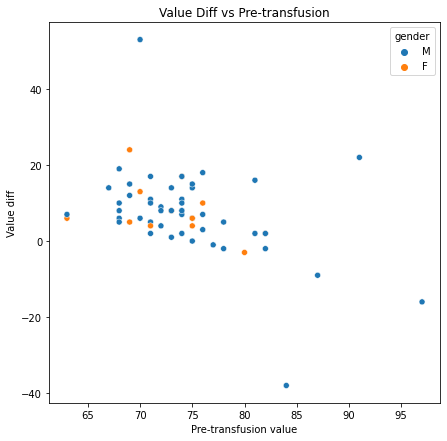

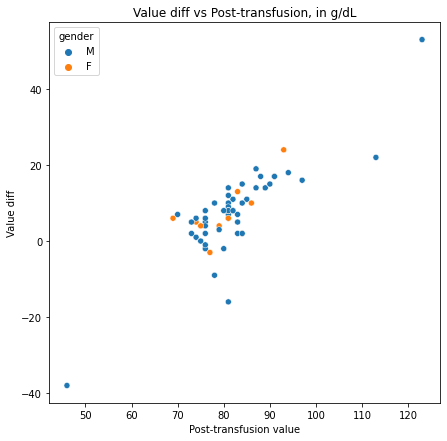

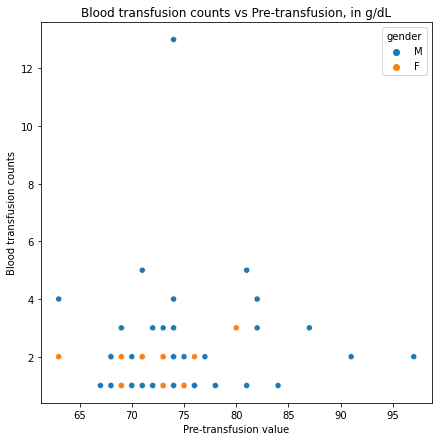

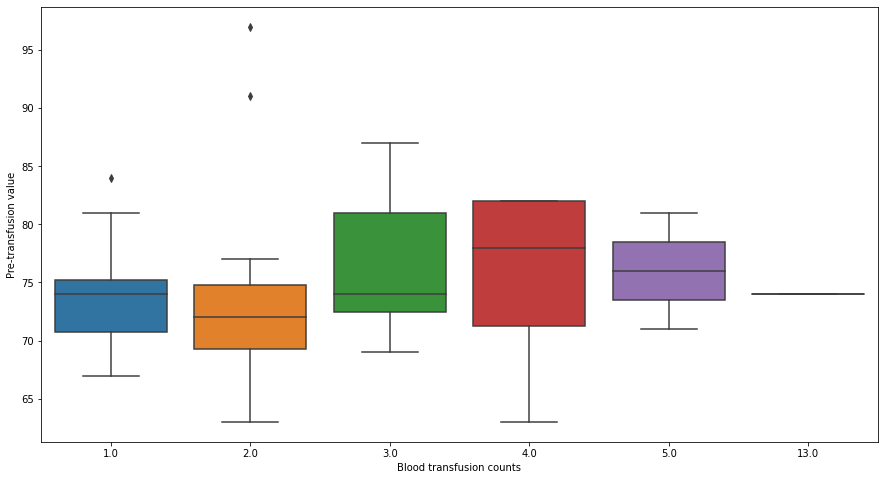

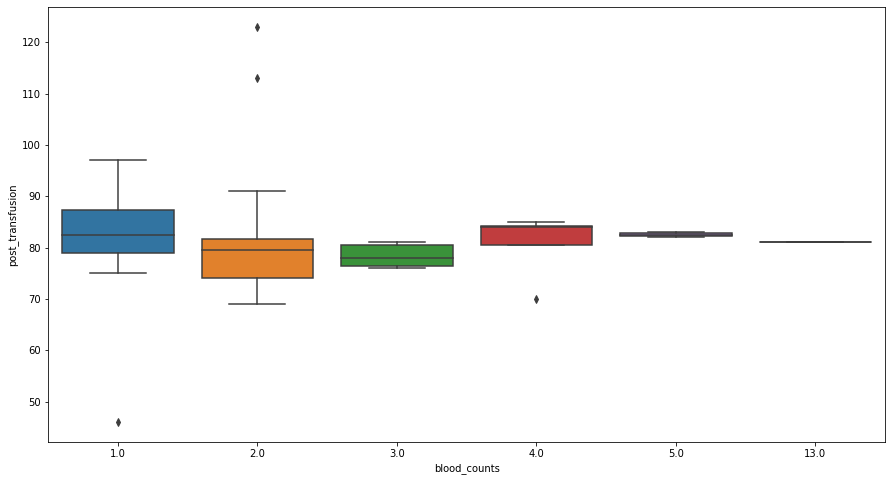

/var/folders/mx/55zzsbtn4yscj7cmdyfv7jg80000gn/T/ipykernel_60110/71590362.py:60: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean= partial_fbt_time_differece_Hb.mean().pre_transfusion
/var/folders/mx/55zzsbtn4yscj7cmdyfv7jg80000gn/T/ipykernel_60110/71590362.py:60: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean= partial_fbt_time_differece_Hb.mean().pre_transfusion
/var/folders/mx/55zzsbtn4yscj7cmdyfv7jg80000gn/T/ipykernel_60110/71590362.py:60: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean= partial_fbt_time_differece_Hb.mean().pre_transfusion
/var/folders/mx/55zzsbtn4yscj7cmdyfv7jg80000gn/T/ipykernel_60110/7159036

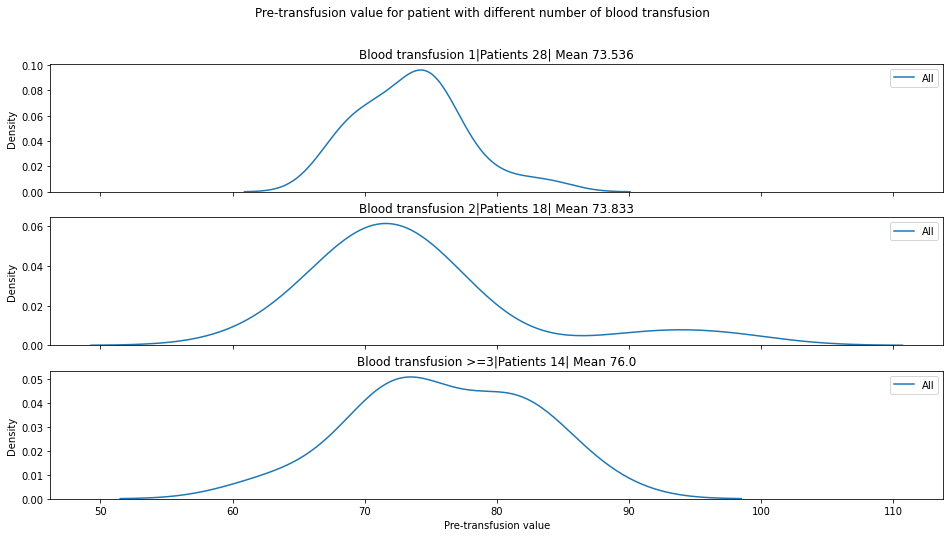

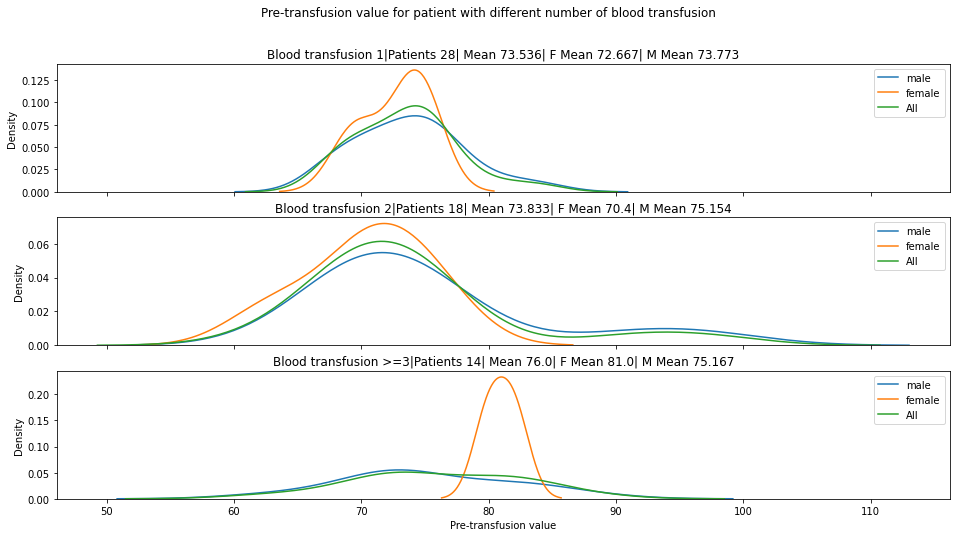

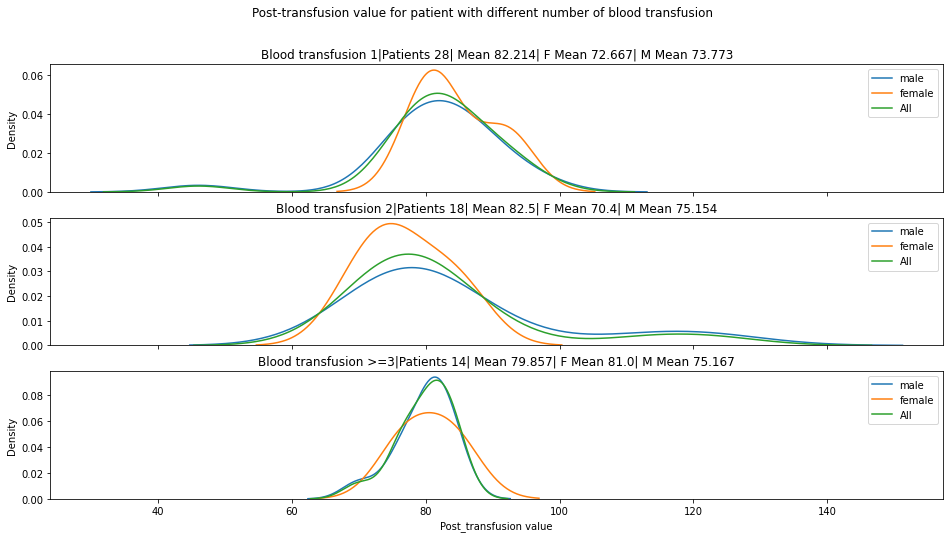

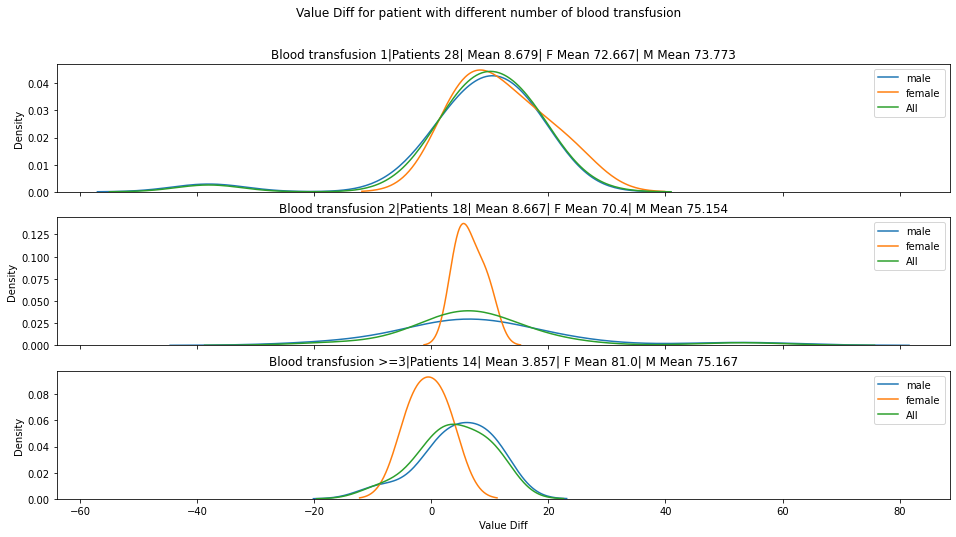

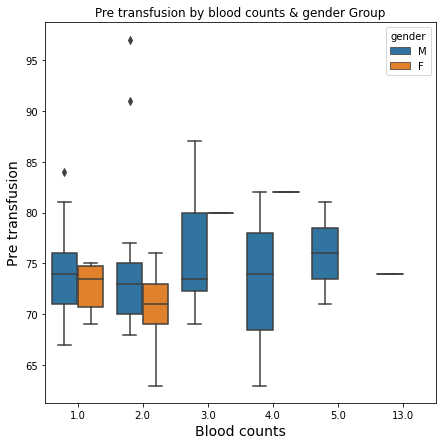

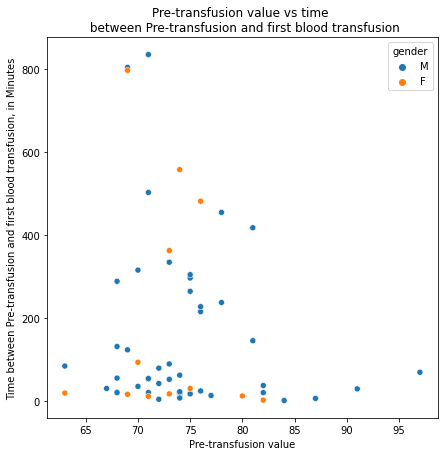

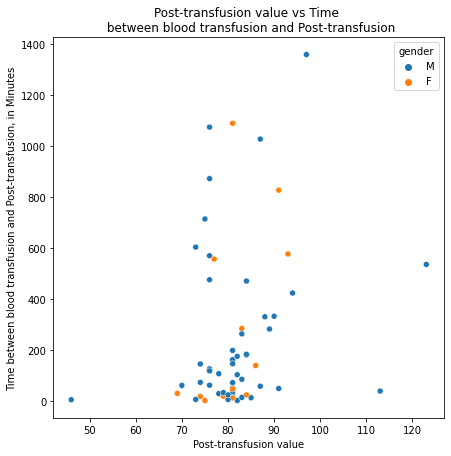

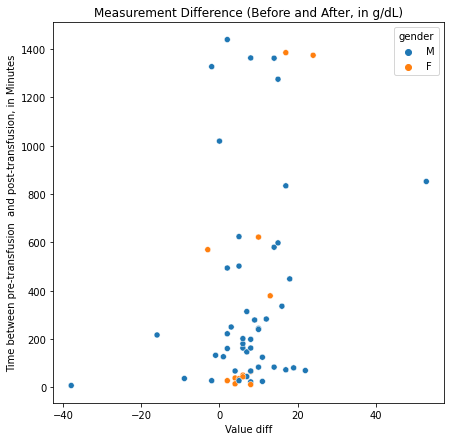

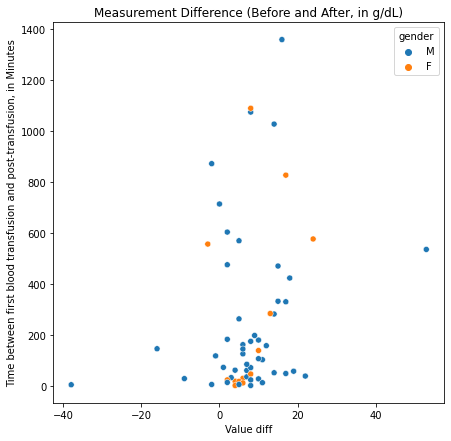

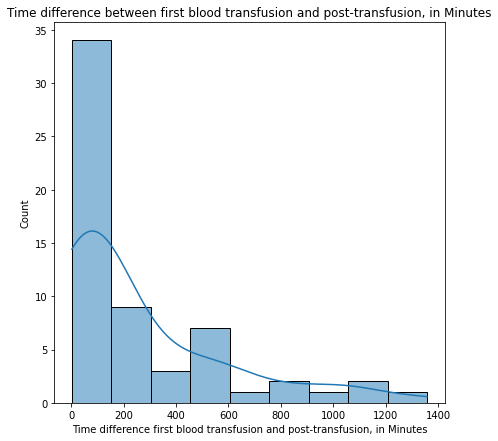

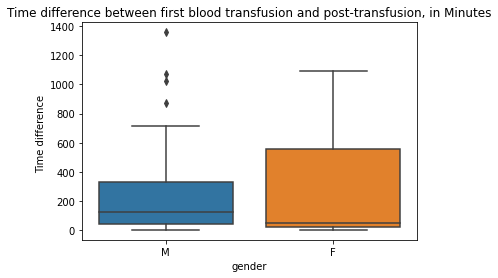

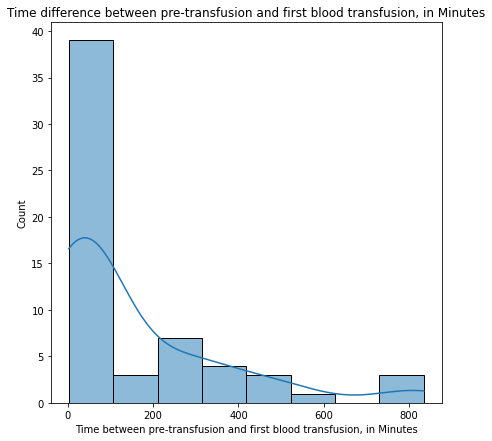

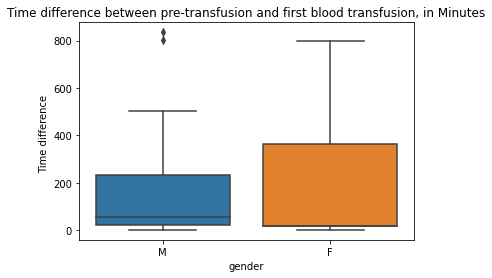

In [15]:
get_EDA(result,"Hemoglobin_EPIC")

In [16]:
df3 = df_icu_stays.drop_duplicates(subset=['PATIENT_NUMBER', 'ICU_START_TIME']).drop(columns=['PATIENT_NUMBER']).join(df_haemoglobins.set_index("ADMISSION_NUMBER"), on="ADMISSION_NUMBER").reset_index()
df3 = df3[(df3.SPECIMEN_TAKEN_TIME < df3.ICU_START_TIME) & ((df3.SPECIMEN_TAKEN_TIME - df3.ICU_START_TIME).dt.seconds/60 <= 1440)][['ADMISSION_NUMBER', 'HAEMOGLOBIN_NUMBER', 'PATIENT_NUMBER']].groupby(["ADMISSION_NUMBER", "PATIENT_NUMBER"]).nunique().reset_index()
df3 = df3.join(df_patients.set_index("PATIENT_NUMBER"), on="PATIENT_NUMBER")[['ADMISSION_NUMBER', 'HAEMOGLOBIN_NUMBER', 'Gender']].rename(columns={"ADMISSION_NUMBER": "hadm_id", "Gender": "gender", "HAEMOGLOBIN_NUMBER": "counts"})
df3 = df3[['hadm_id', 'gender', 'counts']]
hemoglobin_24h_count = df3

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


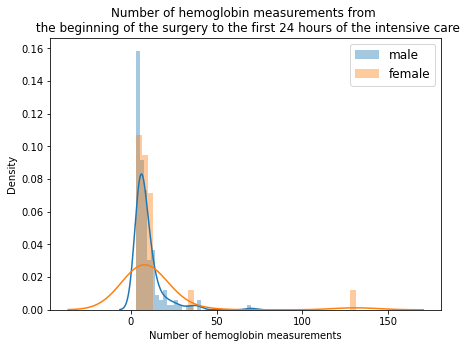

In [17]:
plt.figure(figsize=(7,5))
male_Hb = hemoglobin_24h_count[hemoglobin_24h_count.gender == 'M']
sns.distplot(male_Hb['counts'], label='male')

female_Hb =hemoglobin_24h_count[hemoglobin_24h_count.gender == 'F']
sns.distplot(female_Hb['counts'],label='female')

plt.legend(prop={'size': 12})
plt.title('Number of hemoglobin measurements from \n the beginning of the surgery to the first 24 hours of the intensive care')
plt.xlabel('Number of hemoglobin measurements')
plt.ylabel('Density')
plt.savefig(f'Additional_Hb_plots/EPIC_histplot_numberOfHBmeasurement24H_gender.png')
plt.show()

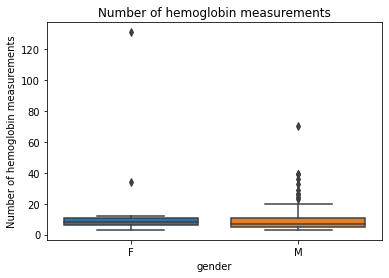

In [18]:
sns.boxplot(x="gender", y='counts', data=hemoglobin_24h_count)
plt.title("Number of hemoglobin measurements")
plt.ylabel('Number of hemoglobin measurements')
plt.savefig(f'Additional_Hb_plots/EPIC_boxplot_numberOfHBmeasurement24H_gender.png')
plt.show()